In [3]:
import librosa
import os
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import random
%matplotlib inline
import IPython.display as ipd
import librosa, librosa.display
import pandas as pd

import numpy as np
import keras
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import GlobalAveragePooling2D, Input, Conv2D, Flatten, Dense, MaxPooling2D,AveragePooling2D, Dropout, UpSampling2D, concatenate, Cropping2D,LeakyReLU, Reshape, BatchNormalization
from keras import optimizers
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
from keras.optimizers import SGD, Adam, Nadam
from keras import regularizers
from keras import backend as K
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

import os
import pickle
import sklearn
import itertools
import math
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd

from custom_layers import PoolHelper, LRN2D

PHONEME_LOCATION= r"PHN/"
SOUND_LOCATION= r"SOUND/"
SPECTROGRAM_LOCATION = r"SPECTROGRAMS/"

# TRAIN_FOLDER = r"data_train"


Using TensorFlow backend.


In [4]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
    
# config = tf.ConfigProto()
# config.gpu_options.allow_growth=True
# sess = tf.Session(config=config)


Default GPU Device: /device:GPU:0


## SpectrogramGenerator

In [3]:
class SpectrogramGenerator:
    def __init__(self,sample_rate = 16000): 
        self.step_frames= 160
        self.window_frames = 4096
        
        self.step_size_ms = int((self.step_frames/sample_rate) * 1000) 
        self.window_size_ms = int((self.window_frames/sample_rate) * 1000)
        
        self.hop_length = 512 
        self.n_fft = 2048
    
    def create_labels(self, starts, ends, phonemes):
        j=0
        labels = []
            
        for i in range(0, ends[-1], self.step_frames):
            if (i > ends[-1] - int(self.window_frames / 2)):
                continue
            if i + self.window_frames / 2 > ends[j]:
                j += 1
            labels.append(phonemes[j])
        
        return labels
    
    def read_phoneme_information(self,file):
        rows = [x.split(' ') for x in open(file).readlines()]

        starts = []
        ends = []
        phonemes = []

        for row in rows:
            starts.append(int(row[0]))
            ends.append(int(row[1]))
            phonemes.append(row[2])  
        return starts, ends, phonemes

    def get_spectrograms(self, wav, max_phones, verbose = 0 ):
        samples, sample_rate = librosa.load(wav,sr=None)
        
        windows = []
        for i in range(0, max_phones[-1], self.step_frames):
            if (i > max_phones[-1] - int(self.window_frames / 2)):
                continue
            windows.append(samples[i: i + self.window_frames])

        spectrograms = []
        n_fft = 160 # N/2 +1
        hop_length = int(n_fft/4)
    
        if(verbose):
            print("Hop length in seconds = ", float(hop_length)/sample_rate)
            print("frame size in seconds = ", float(n_fft)/sample_rate)

        for window in windows:
            X = librosa.stft(window, n_fft = n_fft, hop_length=hop_length)
            S = librosa.amplitude_to_db(abs(X))
            norm_S = (S-np.min(S))/(np.max(S)-np.min(S))
            spectrograms.append(norm_S)
        return spectrograms
        
    
    def label_spectrograms(self, file, dataset ):
        starts, ends, phonemes = self.read_phoneme_information(PHONEME_LOCATION + dataset + r"/" + file +".PHN")
        labels = self.create_labels(starts, ends, phonemes)
        spectrograms = self.get_spectrograms(SOUND_LOCATION + dataset + r"/" + file + ".WAV", ends)
        return spectrograms, labels
                   
    def create_patches(self, file, dataset = "TRAIN/" ):
        spectrograms, labels = self.label_spectrograms(file, dataset)
                       
        i = 0 
        for s, l in zip(spectrograms, labels):
            out_folder = './SPECTROGRAMS/' + dataset + l.rstrip()
            if not os.path.exists(out_folder):
                os.makedirs(out_folder)
            img = Image.fromarray(s*255)
            img = img.convert('L')
            img = img.resize((256,256))
            img.save(out_folder + '/' + file + "_" + str(i) + '.png')
            i+=1
            
                   

## Generating Spectrogram Images
First Training Set and then Test Set

In [4]:
spectrogram_generator = SpectrogramGenerator()

In [5]:
# dataset = "TRAIN/"

# listp = os.listdir(PHONEME_LOCATION+dataset)
# listp[0].split('.')
# # print(listp)

# for idx, file in enumerate(os.listdir(PHONEME_LOCATION+dataset)):
#     if idx % 100 == 0:
#         print("Running at, ", idx, "of total, ", len(os.listdir(PHONEME_LOCATION+dataset)))
#     file_name = file.split('.')[0]
#     spectrogram_generator.create_patches(file_name, dataset)

## Generating Spectrogram Images For Testing

In [6]:
# dataset = "TEST/"
# listp = os.listdir(PHONEME_LOCATION+dataset)
# listp[0].split('.')
# # print(listp)

# for idx, file in enumerate(os.listdir(PHONEME_LOCATION+dataset)):
#     if idx % 100 == 0:
#         print("Running at, ", idx, "of total, ", len(os.listdir(PHONEME_LOCATION+dataset)))
#     file_name = file.split('.')[0]
#     spectrogram_generator.create_patches(file_name, dataset)

## Load Dataset

## Loading Data Location
We load the data such that we can easily retrieve it in the batch creator we will define later

In [19]:
PHONEME_DIRS = [x[0] for x in os.walk(SPECTROGRAM_LOCATION + "TRAIN/") if x[0] != SPECTROGRAM_LOCATION + "TRAIN/"]
PHONEME_DIRS.sort()
PHONEMES = [x.split('/')[-1] for x in PHONEME_DIRS]

number_files = 0
    
N_CLASSES = len(PHONEME_DIRS)

print("Data Location per Phoneme = " ,PHONEME_DIRS)
print("Number of classes = ", N_CLASSES)

Data Location per Phoneme =  ['SPECTROGRAMS/TRAIN/aa', 'SPECTROGRAMS/TRAIN/ae', 'SPECTROGRAMS/TRAIN/ah', 'SPECTROGRAMS/TRAIN/ao', 'SPECTROGRAMS/TRAIN/aw', 'SPECTROGRAMS/TRAIN/ax', 'SPECTROGRAMS/TRAIN/ax-h', 'SPECTROGRAMS/TRAIN/axr', 'SPECTROGRAMS/TRAIN/ay', 'SPECTROGRAMS/TRAIN/b', 'SPECTROGRAMS/TRAIN/bcl', 'SPECTROGRAMS/TRAIN/ch', 'SPECTROGRAMS/TRAIN/d', 'SPECTROGRAMS/TRAIN/dcl', 'SPECTROGRAMS/TRAIN/dh', 'SPECTROGRAMS/TRAIN/dx', 'SPECTROGRAMS/TRAIN/eh', 'SPECTROGRAMS/TRAIN/el', 'SPECTROGRAMS/TRAIN/em', 'SPECTROGRAMS/TRAIN/en', 'SPECTROGRAMS/TRAIN/eng', 'SPECTROGRAMS/TRAIN/epi', 'SPECTROGRAMS/TRAIN/er', 'SPECTROGRAMS/TRAIN/ey', 'SPECTROGRAMS/TRAIN/f', 'SPECTROGRAMS/TRAIN/g', 'SPECTROGRAMS/TRAIN/gcl', 'SPECTROGRAMS/TRAIN/h#', 'SPECTROGRAMS/TRAIN/hh', 'SPECTROGRAMS/TRAIN/hv', 'SPECTROGRAMS/TRAIN/ih', 'SPECTROGRAMS/TRAIN/ix', 'SPECTROGRAMS/TRAIN/iy', 'SPECTROGRAMS/TRAIN/jh', 'SPECTROGRAMS/TRAIN/k', 'SPECTROGRAMS/TRAIN/kcl', 'SPECTROGRAMS/TRAIN/l', 'SPECTROGRAMS/TRAIN/m', 'SPECTROGRAMS/TRAI

In [8]:
def create_validation_train_set(val_split,random_state = 42):
    x = []
    y = []
    for subdir, dirs, files in os.walk(SPECTROGRAM_LOCATION + "TRAIN/"):
        for file in files:
            #print os.path.join(subdir, file)
            filepath = subdir + os.sep + file

            if filepath.endswith(".png"):
                x.append(filepath)
                y.append(subdir.split('/')[-1])
#                 print(filepath)
#                 print(subdir)

    X_train,X_val,y_train,y_val = train_test_split(x,y,test_size = 0.1, shuffle = True,random_state = 42)
    
    uniques, counts = np.unique(y_train, return_counts = True)
    size = len(y_train)
    p = [x/size for x in counts]
    phoneme_dict_percentages = dict(zip(uniques, p))
    phoneme_dict_counts = dict(zip(uniques,counts))
    
    ps = []
    for phoneme in y_train:
        ps.append(phoneme_dict_percentages[phoneme]/phoneme_dict_counts[phoneme])
    
    d = {'instance':X_train,'p':ps}
    X_train= pd.DataFrame(d)
     
    
    uniques, counts = np.unique(y_val, return_counts = True)
    size = len(y_val)
    p = [x/size for x in counts]
    phoneme_dict_percentages = dict(zip(uniques, p))
    phoneme_dict_counts = dict(zip(uniques,counts))
    
    ps = []
    for phoneme in y_val:
         ps.append(phoneme_dict_percentages[phoneme]/phoneme_dict_counts[phoneme])
    
    d = {'instance':X_val,'p':ps}
    X_val= pd.DataFrame(d)
     
    
    return X_train,X_val,y_train,y_val

In [9]:
X_train,X_val,y_train,y_val= create_validation_train_set(0.1)
TRAIN_DATASET = X_train
VALIDATION_DATASET = X_val

##  Plot of Training Data

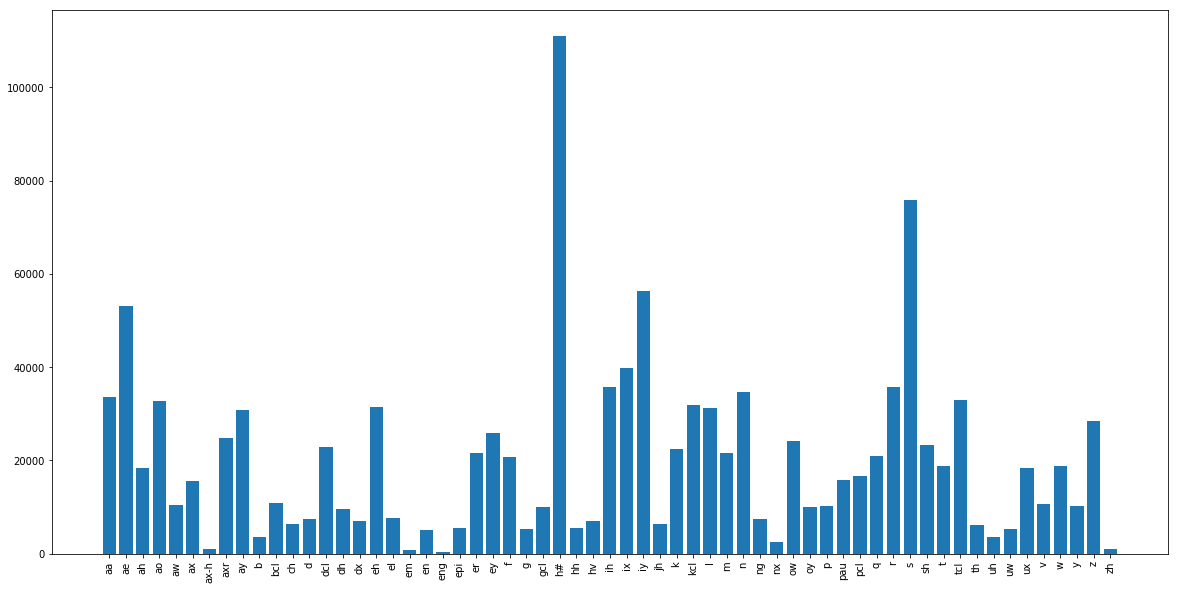

In [10]:
unique, counts = np.unique(np.asarray(y_train),return_counts =True)
plt.rcParams['figure.figsize'] = 20, 10
plt.bar(unique,counts)
plt.xticks(rotation=90)
plt.show()

## Plot Validation Data

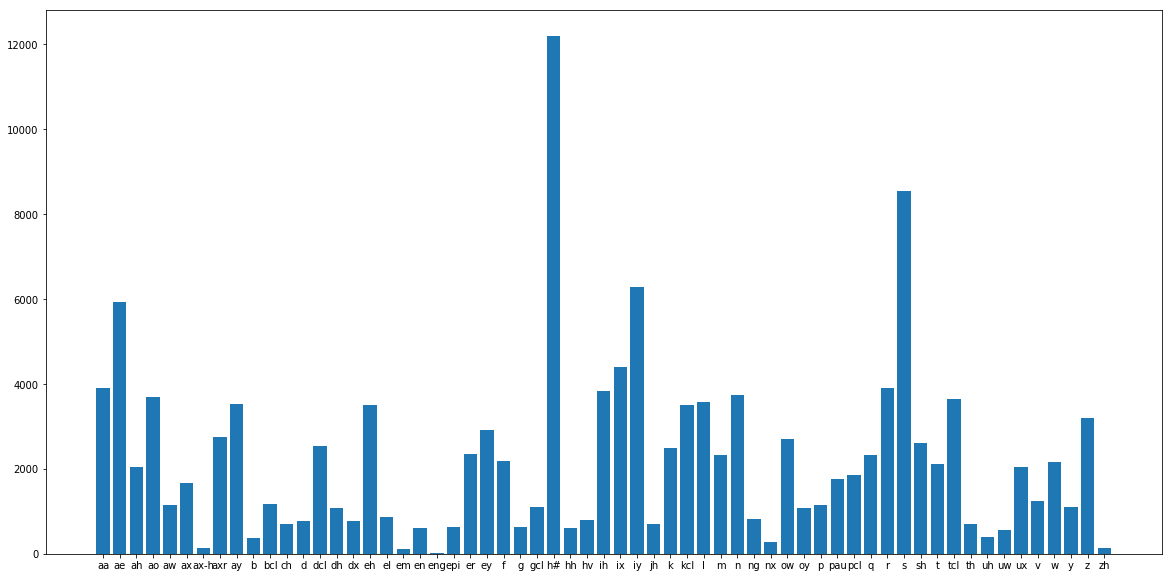

In [11]:
unique, counts = np.unique(np.asarray(y_val),return_counts =True)
plt.bar(unique,counts)
plt.show()

## PatchExtractor

In [12]:
class PatchExtractor:

    def __init__(self, patch_size=(256,256), max_rotation=0, flipping=False):
        self.patch_size = patch_size 
        self.flipping = flipping
        self.max_rotation = max_rotation

        
    def get_patch(self, image, location=[0,0]):
        ''' 
        image: a numpy array representing the input image
        location: a tuple with an y and x coordinate
        
        This method normalizes the patch
        
        return a patch from the image at `location`, representing the top left corner of the patch
        if self.flipping = True, there is a 50% chance the patch is horizontally flipped   
        we will not rotate it or perform other augmentations for now to speed up the training process
        '''
        y, x = location      
        h, w = self.patch_size 
        
#         image  = np.stack((image,)*3, axis=-1)
#         image = np.squeeze(np.stack((image,) * 3, -1)) 
#         print("Image shape = ", image.shape)
        
        # - patch should be a numpy array of size <h, w>
        (image_h, image_w,channels) = image.shape
        
        if (h + y > image_h | w + x > image_x):
            print("Exceeding Bounds")
            return None
        
        # - the patch should be normalized (intensity values between 0-1)
        patch = image[y: y + h, x : x + w, :]
        
#         patch = (patch-np.min(patch))/(np.max(patch)-np.min(patch))
        patch = patch / 255.0    
        
        return patch

## BatchCreator
Now it's time to create a BatchCreator. The BatchCreator will allow us to generate batches to train on. These batches contain a set of (class-balanced) samples or patches, and their corresponding labels. The data returned by the BatchCreator can directly be fed into the neural network for training or classification.

In [13]:
class BatchCreator:
    
    def __init__(self, patch_extractor, dataset, balanced = True):
#         self.dataset = dataset
        self.patch_extractor = patch_extractor
        self.dataset = dataset
        self.balanced = balanced
        self.enc = OneHotEncoder(handle_unknown='ignore',sparse = False)
    
        self.enc.fit(np.asarray(PHONEMES).reshape(-1,1))
                    
    def load_img(self,path):
        img = np.array(Image.open(path))
        img = np.expand_dims(img, axis=2)
        return img
    
    def create_batch(self, batch_size,n_outputs=1, use_patches = False):
        '''
        returns a class-balanced array of patches (x) with corresponding labels (y) in one-hot structure
        patches are by default full image
        '''
        
        n_patches_per_class = int(math.ceil(batch_size/N_CLASSES))

        # We have to shuffle the list of dirs such that we loop differently through the list every time
#         phoneme_dirs = PHONEME_DIRS[:]
#         random.shuffle(phoneme_dirs)

#         x_data = np.zeros((batch_size, *(256,256), 1))
#         y_data = np.zeros((batch_size, N_CLASSES)) # one-hot encoding

#         index = 0
        if self.balanced:
            data = np.random.choice(self.dataset['instance'],batch_size,p = self.dataset['p'])
        else:
            data = np.random.choice(self.dataset['instance'],batch_size)
        x_data = np.asarray([self.patch_extractor.get_patch(self.load_img(x)) for x in data])
        y_data = np.asarray([self.enc.transform(np.asarray(x.split('/'))[-2].reshape(-1,1)) for x in data]).reshape(batch_size,61)
        
#         for i,phoneme_dir in enumerate(phoneme_dirs):
#             for j in range(0,n_patches_per_class): 
#                 if index>=(batch_size):
# #                     print("BREAKING FOR LOOP BECAUSE = ", index, "and",batch_size-1 )
#                     break
#                 img_file = random.choice(self.dataset[0])
#                 img = self.load_img(phoneme_dir + '/' + img_file)
#                 patch = self.patch_extractor.get_patch(img)
#                 x_data[index] = patch
#                 y_data[index,PHONEME_DIRS.index(phoneme_dir)] = 1
#                 index = index + 1
        if n_outputs == 1:
            return x_data,y_data
        else:
            return x_data,[y_data,y_data,y_data]
        
    def get_generator(self, batch_size,n_outputs=1):
        '''returns a generator that will yield batches infinitely'''
        while True:
            yield self.create_batch(batch_size,n_outputs)

## Visualize BatchCreator

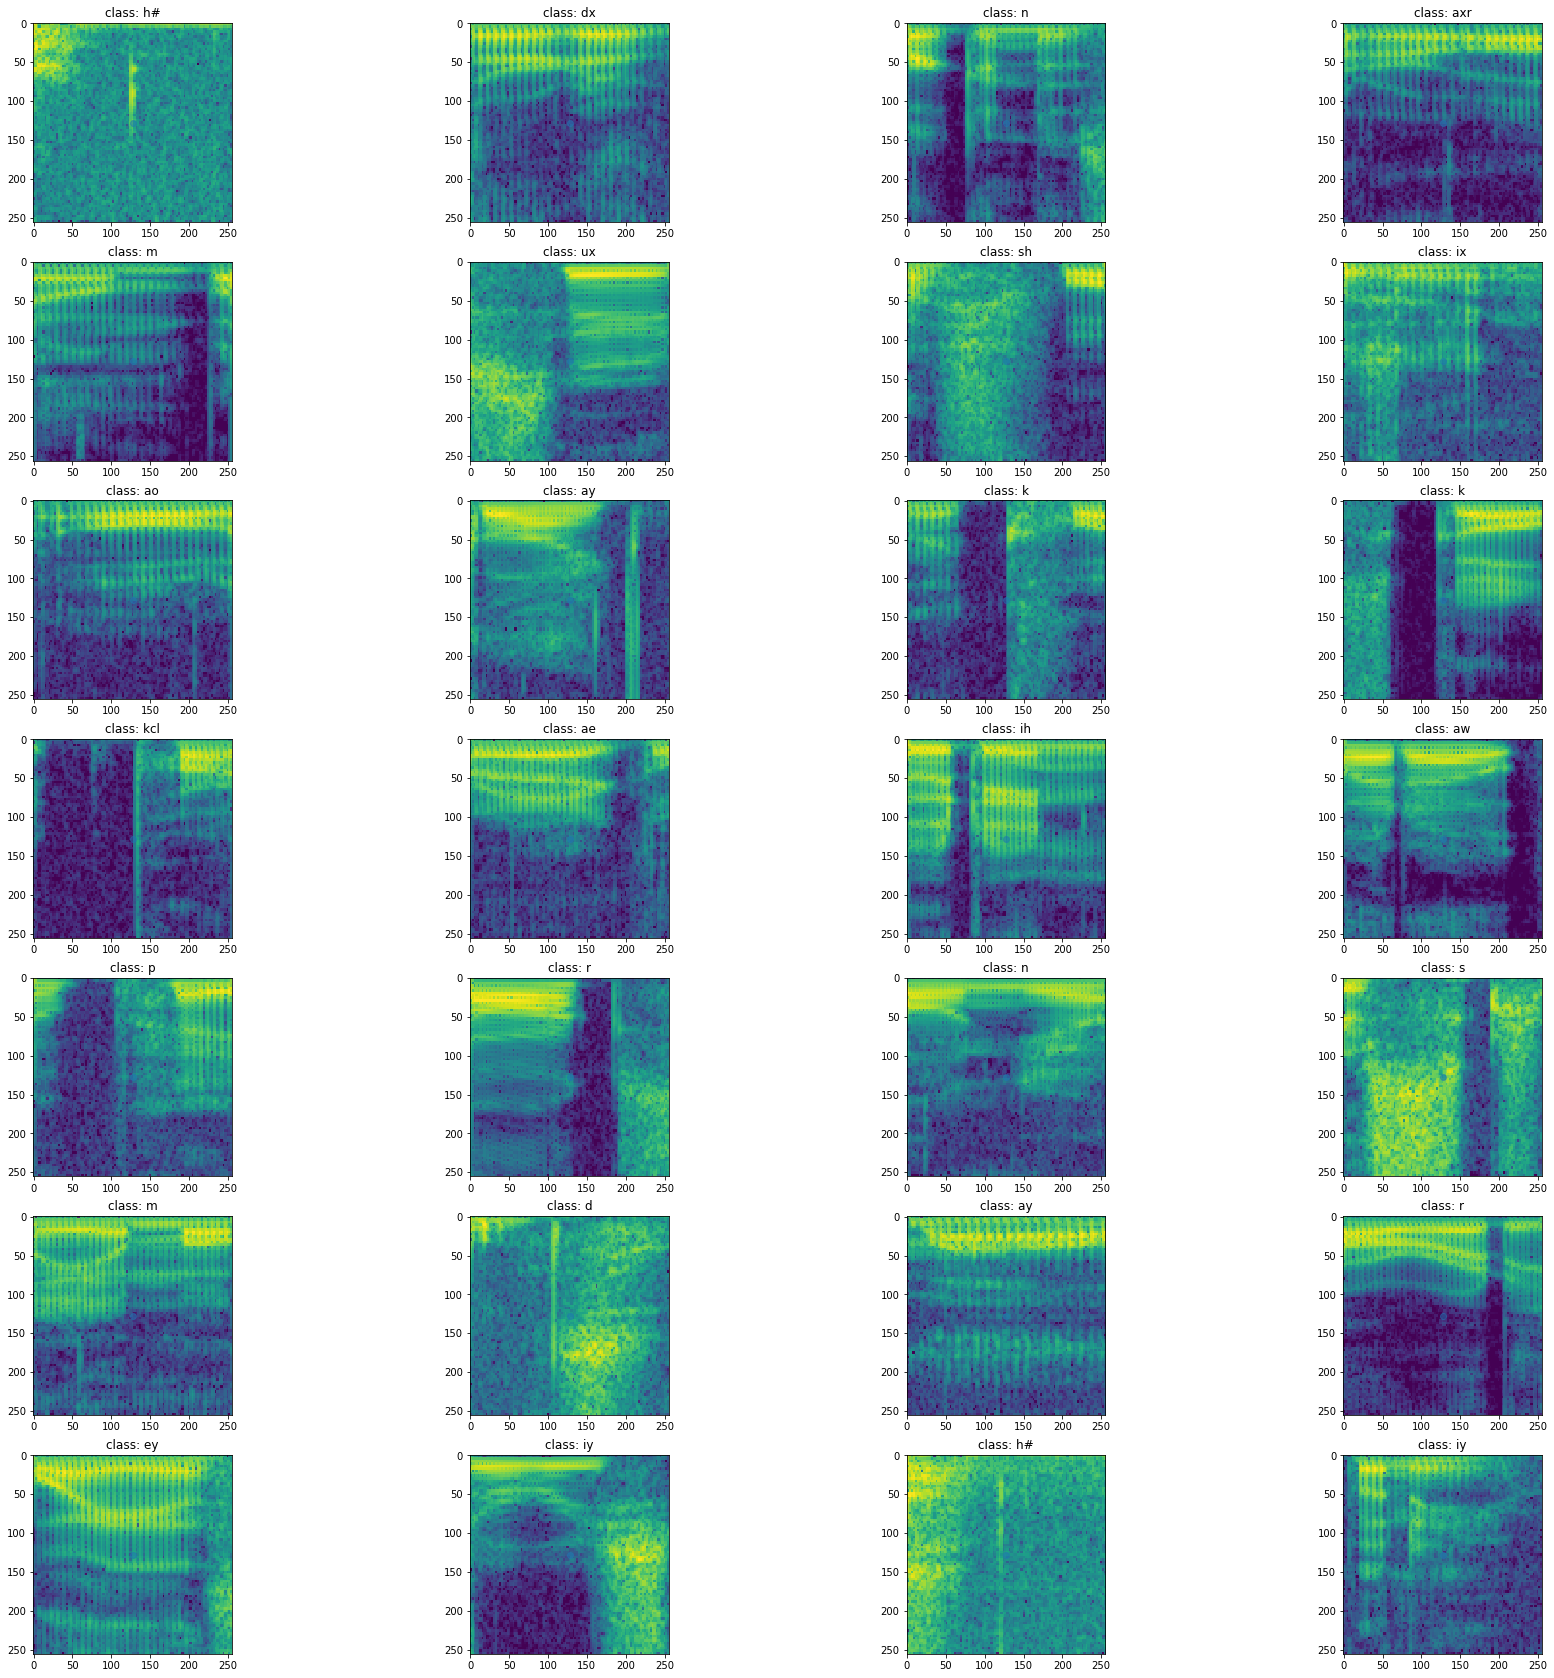

In [14]:
PATCH_SIZE = (256,256)
PATCH_EXTRACTOR = PatchExtractor(PATCH_SIZE)
BATCH_CREATOR = BatchCreator(PATCH_EXTRACTOR,TRAIN_DATASET)


# create a batch
x, y = BATCH_CREATOR.create_batch(256)

# visualize it
matplotlib.rcParams['figure.figsize'] = (30, 30)
f, axes = plt.subplots(7, 4)

for ax_row in axes:
    for ax in ax_row:
        i = random.randint(0,255)
        ax.imshow(np.squeeze(x[i]))
        ax.set_title('class: {}'.format(PHONEME_DIRS[np.argmax(y[i])].split('/')[2]))
        ax.scatter(*[p/2 for p in PATCH_EXTRACTOR.patch_size], alpha=0.5)
#         i += 1
plt.show()

del PATCH_SIZE, PATCH_EXTRACTOR, BATCH_CREATOR

# Neural Network

## Inception Model
First we make a inception module function

![title](inception_module.png)

![title](googlenet.png)

https://arxiv.org/pdf/1409.4842v1.pdf

In [5]:
def inception_module_3a(inputs):
    padding = 'same'
    
    # Tower 0
    tower_0 = Conv2D(64,(1,1),padding=padding, activation='relu')(inputs)
    
    # Tower 1
    tower_1 = Conv2D(96, (1,1), padding=padding, activation='relu')(inputs)
    tower_1 = Conv2D(128, (3,3), padding=padding, activation='relu')(tower_1)
    
    # Tower 2
    tower_2 = Conv2D(16, (1,1), padding=padding, activation='relu')(inputs)
    tower_2 = Conv2D(32, (5,5), padding=padding, activation='relu')(tower_2)
    
    # Tower 3
    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding=padding)(inputs)
    tower_3 = Conv2D(32, (1,1), padding=padding, activation='relu')(tower_3)
    
    # concatenation
    output = concatenate([tower_1, tower_2, tower_3], axis = 3)
    
    return output


In [6]:
def inception_module_3b(inputs):
    padding = 'same'
    
    # Tower 0
    tower_0 = Conv2D(128,(1,1),padding=padding, activation='relu')(inputs)
    
    # Tower 1
    tower_1 = Conv2D(128, (1,1), padding=padding, activation='relu')(inputs)
    tower_1 = Conv2D(192, (3,3), padding=padding, activation='relu')(tower_1)
    
    # Tower 2
    tower_2 = Conv2D(32, (1,1), padding=padding, activation='relu')(inputs)
    tower_2 = Conv2D(96, (5,5), padding=padding, activation='relu')(tower_2)
    
    # Tower 3
    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding=padding)(inputs)
    tower_3 = Conv2D(64, (1,1), padding=padding, activation='relu')(tower_3)
    
    # concatenation
    output = concatenate([tower_1, tower_2, tower_3], axis = 3)
    
    return output

In [7]:
def inception_module_4a(inputs):
    padding = 'same'
    
    # Tower 0
    tower_0 = Conv2D(192,(1,1),padding=padding, activation='relu')(inputs)
    
    # Tower 1
    tower_1 = Conv2D(96, (1,1), padding=padding, activation='relu')(inputs)
    tower_1 = Conv2D(208, (3,3), padding=padding, activation='relu')(tower_1)
    
    # Tower 2
    tower_2 = Conv2D(16, (1,1), padding=padding, activation='relu')(inputs)
    tower_2 = Conv2D(48, (5,5), padding=padding, activation='relu')(tower_2)
    
    # Tower 3
    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding=padding)(inputs)
    tower_3 = Conv2D(64, (1,1), padding=padding, activation='relu')(tower_3)
    
    # concatenation
    output = concatenate([tower_1, tower_2, tower_3], axis = 3)
    
    return output

In [8]:
def inception_module_4b(inputs):
    padding = 'same'
    
    # Tower 0
    tower_0 = Conv2D(160,(1,1),padding=padding, activation='relu')(inputs)
    
    # Tower 1
    tower_1 = Conv2D(112, (1,1), padding=padding, activation='relu')(inputs)
    tower_1 = Conv2D(224, (3,3), padding=padding, activation='relu')(tower_1)
    
    # Tower 2
    tower_2 = Conv2D(24, (1,1), padding=padding, activation='relu')(inputs)
    tower_2 = Conv2D(64, (5,5), padding=padding, activation='relu')(tower_2)
    
    # Tower 3
    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding=padding)(inputs)
    tower_3 = Conv2D(64, (1,1), padding=padding, activation='relu')(tower_3)
    
    # concatenation
    output = concatenate([tower_1, tower_2, tower_3], axis = 3)
    
    return output

In [9]:
def inception_module_4c(inputs):
    padding = 'same'
    
    # Tower 0
    tower_0 = Conv2D(128,(1,1),padding=padding, activation='relu')(inputs)
    
    # Tower 1
    tower_1 = Conv2D(128, (1,1), padding=padding, activation='relu')(inputs)
    tower_1 = Conv2D(256, (3,3), padding=padding, activation='relu')(tower_1)
    
    # Tower 2
    tower_2 = Conv2D(24, (1,1), padding=padding, activation='relu')(inputs)
    tower_2 = Conv2D(64, (5,5), padding=padding, activation='relu')(tower_2)
    
    # Tower 3
    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding=padding)(inputs)
    tower_3 = Conv2D(64, (1,1), padding=padding, activation='relu')(tower_3)
    
    # concatenation
    output = concatenate([tower_1, tower_2, tower_3], axis = 3)
    
    return output

In [10]:
def inception_module_4d(inputs):
    padding = 'same'
    
    # Tower 0
    tower_0 = Conv2D(112,(1,1),padding=padding, activation='relu')(inputs)
    
    # Tower 1
    tower_1 = Conv2D(144, (1,1), padding=padding, activation='relu')(inputs)
    tower_1 = Conv2D(288, (3,3), padding=padding, activation='relu')(tower_1)
    
    # Tower 2
    tower_2 = Conv2D(32, (1,1), padding=padding, activation='relu')(inputs)
    tower_2 = Conv2D(64, (5,5), padding=padding, activation='relu')(tower_2)
    
    # Tower 3
    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding=padding)(inputs)
    tower_3 = Conv2D(64, (1,1), padding=padding, activation='relu')(tower_3)
    
    # concatenation
    output = concatenate([tower_1, tower_2, tower_3], axis = 3)
    
    return output

In [11]:
def inception_module_4e(inputs):
    padding = 'same'
    
    # Tower 0
    tower_0 = Conv2D(256,(1,1),padding=padding, activation='relu')(inputs)
    
    # Tower 1
    tower_1 = Conv2D(160, (1,1), padding=padding, activation='relu')(inputs)
    tower_1 = Conv2D(320, (3,3), padding=padding, activation='relu')(tower_1)
    
    # Tower 2
    tower_2 = Conv2D(32, (1,1), padding=padding, activation='relu')(inputs)
    tower_2 = Conv2D(128, (5,5), padding=padding, activation='relu')(tower_2)
    
    # Tower 3
    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding=padding)(inputs)
    tower_3 = Conv2D(128, (1,1), padding=padding, activation='relu')(tower_3)
    
    # concatenation
    output = concatenate([tower_1, tower_2, tower_3], axis = 3)
    
    return output

In [12]:
def inception_module_5a(inputs):
    padding = 'same'
    
    # Tower 0
    tower_0 = Conv2D(256,(1,1),padding=padding, activation='relu')(inputs)
    
    # Tower 1
    tower_1 = Conv2D(160, (1,1), padding=padding, activation='relu')(inputs)
    tower_1 = Conv2D(320, (3,3), padding=padding, activation='relu')(tower_1)
    
    # Tower 2
    tower_2 = Conv2D(32, (1,1), padding=padding, activation='relu')(inputs)
    tower_2 = Conv2D(128, (5,5), padding=padding, activation='relu')(tower_2)
    
    # Tower 3
    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding=padding)(inputs)
    tower_3 = Conv2D(128, (1,1), padding=padding, activation='relu')(tower_3)
    
    # concatenation
    output = concatenate([tower_1, tower_2, tower_3], axis = 3)
    
    return output

In [13]:
def inception_module_5b(inputs):
    padding = 'same'
    
    # Tower 0
    tower_0 = Conv2D(384,(1,1),padding=padding, activation='relu')(inputs)
    
    # Tower 1
    tower_1 = Conv2D(192, (1,1), padding=padding, activation='relu')(inputs)
    tower_1 = Conv2D(384, (3,3), padding=padding, activation='relu')(tower_1)
    
    # Tower 2
    tower_2 = Conv2D(48, (1,1), padding=padding, activation='relu')(inputs)
    tower_2 = Conv2D(128, (5,5), padding=padding, activation='relu')(tower_2)
    
    # Tower 3
    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding=padding)(inputs)
    tower_3 = Conv2D(128, (1,1), padding=padding, activation='relu')(tower_3)
    
    # concatenation
    output = concatenate([tower_1, tower_2, tower_3], axis = 3)
    
    return output

In [14]:
def inception_stem(inputs):
    # 7x7 conv with stride = 2
    conv1 = Conv2D(64,kernel_size = (7,7),strides=(2,2),padding='same', activation ='relu')(inputs)
    
    # MaxPoolingLayer with 3x3 stride = 2
    maxPool1 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(conv1)
    
#     bn1 = BatchNormalization()(maxPool1)
    
    lrn1 = LRN2D()(maxPool1)

    
    conv2 = Conv2D(64,kernel_size = (1,1),strides=(1,1),padding='valid', activation ='relu')(lrn1)
    
    conv3 = Conv2D(192,kernel_size = (3,3),strides=(1,1),padding='same', activation ='relu')(conv2)
    
#     bn2 = BatchNormalization()(conv3)
    lrn2 = LRN2D()(conv3)
    
    maxPool2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(lrn2)
    
    return maxPool2

    
    # Maybe we need batchnormalization or local response normalization
    

In [15]:
def build_classifier(inputs,n_classes):
    
    averagePool1 = AveragePooling2D(pool_size=(7,7),strides=(1,1),padding='valid')(inputs)
    flat = Flatten()(inputs)
    dropout1 = Dropout(0.4)(flat)
    
    dense1 = Dense(n_classes,activation='softmax')(dropout1)
    
    return dense1
    

In [16]:
def build_multi_task(inputs,n_classes):
    averagePool1 = AveragePooling2D(pool_size=(5,5),strides=(3,3),padding='valid')(inputs)
    
    conv1 = Conv2D(128,kernel_size = (1,1),strides=(1,1),padding='same', activation ='relu')(averagePool1)
    flat1 = Flatten()(conv1)
    dense1 = Dense(1024, activation = 'relu')(flat1)
    dropout1 = Dropout(0.7)(dense1)
    dense2 = Dense(n_classes,activation='softmax')(dropout1)
    
    return dense2

In [20]:
def build_inception_small(n_classes=N_CLASSES):
    inputs = Input(shape=(256, 256, 1))
    
    stem = inception_stem(inputs)
    
    module3a = inception_module_3a(stem)
    
    classifier = build_classifier(module3a,n_classes)
    
    model = Model(inputs, classifier)
    
    return model

In [22]:
def build_inception_v1(n_classes=N_CLASSES):
    inputs = Input(shape=(256, 256, 1))
    
    stem = inception_stem(inputs,)
    
    module3a = inception_module_3a(stem)
    module3b = inception_module_3b(module3a)
    
    maxPool1 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(module3b)
    
    module4a = inception_module_4a(maxPool1)
    
    multi_task1 = build_multi_task(module4a,n_classes)
    
    module4b = inception_module_4b(module4a)
    module4c = inception_module_4c(module4b)
    module4d = inception_module_4d(module4c)
    
    multi_task2 = build_multi_task(module4d,n_classes)
    
    module4e = inception_module_4e(module4d)
    
    maxPool2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(module4e)
    
    module5a = inception_module_5a(maxPool2)
    module5b = inception_module_5b(module5a)
    
    classifier = build_classifier(module5b,n_classes)
    
    model = Model(inputs, [classifier,multi_task1, multi_task2])
    
    return model

In [23]:
def top3_accuracy(y_true, y_pred):
    return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)
def top5_accuracy(y_true,y_pred):
    return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)

## Train Models
We define our own function for training a model

In [32]:
# function to train a model
def train_model(model, training_params, use_class_weights=False, crop=False, crop_size=(0,0)):
    
    patch_size = training_params['patch_size']
    batch_size = training_params['batch_size']
    loss = training_params['loss']
    metrics = training_params['metrics']
    epochs = training_params['epochs']
    steps_per_epoch = training_params['steps_per_epoch']
    optimizer = training_params['optimizer']
#     training_dataset = training_params['training_dataset']
    validation_size = training_params['validation_size']
    validation_steps = training_params['validation_steps']
    stop = training_params['stop']
    n_outputs = training_params['n_outputs']
    
    str_name = training_params['name'] +'_'+ str(batch_size) + '_' + str(epochs) + '_' + str(steps_per_epoch) + '_' + str(validation_size * validation_steps)
    # batch generator 
    patch_generator = PatchExtractor(patch_size)
    
    train_batch_generator = BatchCreator(patch_generator,dataset = TRAIN_DATASET, balanced=True)
    train_image_generator = train_batch_generator.get_generator(batch_size,n_outputs)
    
    validation_batch_generator = BatchCreator(patch_generator, dataset = VALIDATION_DATASET,balanced=False)
    validation_image_generator = validation_batch_generator.get_generator(validation_size,n_outputs)

    # compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    filepath = "_saved-model-{epoch:02d}.hdf5"
    # train the model
    # callbacks
    checker = ModelCheckpoint('models/' + str_name + filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='auto')
#     checker = ModelCheckpoint('models/phoneme.best.hdf5', monitor='loss',
#                                         verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    saver = ModelCheckpoint('models/phoneme_models_' + str_name + '.h5', monitor='loss', verbose=1,
                                      save_best_only=True, save_weights_only=True, mode='auto', period=1)
    tb =TensorBoard(log_dir='logs/' + str_name, histogram_freq=0,
                               write_graph=False, write_images=True)
    stopper = EarlyStopping(monitor='loss', min_delta=0.001, patience=stop, verbose=0, mode='auto')

    
    
    
    history = model.fit_generator(generator=train_image_generator, callbacks=[checker, tb, stopper, saver], steps_per_epoch=steps_per_epoch, 
                            epochs=epochs, validation_data=validation_image_generator,validation_steps = validation_steps)
    return history

In [31]:
model = build_inception_small()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 3200        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
lr_n2d_1 (LRN2D)                (None, 64, 64, 64)   0           max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
conv2d_2 (

In [30]:
model = build_inception_v1()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 3200        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
lr_n2d_1 (LRN2D)                (None, 64, 64, 64)   0           max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
conv2d_2 (

### Inception Small

In [ ]:
inception_model_small = build_inception_small()

plt.rcParams['figure.figsize'] = 10, 5
training_params = {}
training_params['name'] ='inception_small'
training_params['learning_rate'] = 0.001
training_params['patch_size'] = (256, 256) # input size
training_params['batch_size'] = 61 * 3 # number of patches in a mini-batch
training_params['steps_per_epoch'] = 100
training_params['epochs'] = 200
training_params['optimizer'] = SGD(lr=training_params['learning_rate'], momentum=0.9, nesterov=True)
#training_params['optimizer'] = Adam()
training_params['loss'] = ['categorical_crossentropy']
training_params['n_outputs'] = 1

training_params['metrics'] = ['accuracy',top3_accuracy,top5_accuracy]


training_params['validation_size'] = 64 
training_params['validation_steps'] = 20
training_params['stop'] = 50 # N|umber of epochs with no increase for EarlyStopping

history_small = train_model(inception_model_small, training_params)

# Inception V1

In [33]:
inception_model_v1 = build_inception_v1()
# print(inception_model_v1.summary())

plt.rcParams['figure.figsize'] = 10, 5
training_params = {}
training_params['name'] ='inception_v1_correct'
training_params['learning_rate'] = 0.001
training_params['patch_size'] = (256, 256) # input size
training_params['batch_size'] = 61*3 # number of patches in a mini-batch
training_params['steps_per_epoch'] = 100
training_params['epochs'] = 200
training_params['optimizer'] = SGD(lr=training_params['learning_rate'], momentum=0.9, nesterov=True)
#training_params['optimizer'] = Adam()
training_params['loss'] = ['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy']
training_params['n_outputs'] = 3
training_params['metrics'] = ['accuracy',top3_accuracy,top5_accuracy]

training_params['validation_size'] = 64 
training_params['validation_steps'] =20
training_params['stop'] = 50 # Number of epochs with no increase for EarlyStopping

history_v1 = train_model(inception_model_v1, training_params)

Epoch 1/200
100/100 [==============================] - 85s 854ms/step - loss: 12.2847 - dense_15_loss: 4.0919 - dense_12_loss: 4.0973 - dense_14_loss: 4.0956 - dense_15_acc: 0.0884 - dense_15_top3_accuracy: 0.1911 - dense_15_top5_accuracy: 0.2572 - dense_12_acc: 0.0735 - dense_12_top3_accuracy: 0.1446 - dense_12_top5_accuracy: 0.1920 - dense_14_acc: 0.0825 - dense_14_top3_accuracy: 0.1673 - dense_14_top5_accuracy: 0.2198 - val_loss: 12.2183 - val_dense_15_loss: 4.0604 - val_dense_12_loss: 4.0807 - val_dense_14_loss: 4.0772 - val_dense_15_acc: 0.0813 - val_dense_15_top3_accuracy: 0.1828 - val_dense_15_top5_accuracy: 0.2609 - val_dense_12_acc: 0.0813 - val_dense_12_top3_accuracy: 0.1773 - val_dense_12_top5_accuracy: 0.2539 - val_dense_14_acc: 0.0813 - val_dense_14_top3_accuracy: 0.1922 - val_dense_14_top5_accuracy: 0.2617

Epoch 00001: saving model to models/inception_v1_correct_183_200_100_1280_saved-model-01.hdf5

Epoch 00001: loss improved from inf to 12.28472, saving model to models/


Epoch 00008: saving model to models/inception_v1_correct_183_200_100_1280_saved-model-08.hdf5

Epoch 00008: loss improved from 10.12493 to 9.45385, saving model to models/phoneme_models_inception_v1_correct_183_200_100_1280.h5
Epoch 9/200
100/100 [==============================] - 78s 777ms/step - loss: 8.8978 - dense_15_loss: 2.6136 - dense_12_loss: 3.1503 - dense_14_loss: 3.1339 - dense_15_acc: 0.2855 - dense_15_top3_accuracy: 0.5083 - dense_15_top5_accuracy: 0.6306 - dense_12_acc: 0.1998 - dense_12_top3_accuracy: 0.3678 - dense_12_top5_accuracy: 0.4751 - dense_14_acc: 0.2019 - dense_14_top3_accuracy: 0.3766 - dense_14_top5_accuracy: 0.4862 - val_loss: 8.2030 - val_dense_15_loss: 2.4257 - val_dense_12_loss: 2.8990 - val_dense_14_loss: 2.8784 - val_dense_15_acc: 0.3258 - val_dense_15_top3_accuracy: 0.5563 - val_dense_15_top5_accuracy: 0.6867 - val_dense_12_acc: 0.2555 - val_dense_12_top3_accuracy: 0.4437 - val_dense_12_top5_accuracy: 0.5570 - val_dense_14_acc: 0.2578 - val_dense_14_t


Epoch 00016: saving model to models/inception_v1_correct_183_200_100_1280_saved-model-16.hdf5

Epoch 00016: loss improved from 7.26680 to 7.09016, saving model to models/phoneme_models_inception_v1_correct_183_200_100_1280.h5
Epoch 17/200
100/100 [==============================] - 79s 792ms/step - loss: 6.9364 - dense_15_loss: 1.8179 - dense_12_loss: 2.6506 - dense_14_loss: 2.4679 - dense_15_acc: 0.4658 - dense_15_top3_accuracy: 0.7237 - dense_15_top5_accuracy: 0.8223 - dense_12_acc: 0.2849 - dense_12_top3_accuracy: 0.5009 - dense_12_top5_accuracy: 0.6187 - dense_14_acc: 0.3229 - dense_14_top3_accuracy: 0.5571 - dense_14_top5_accuracy: 0.6728 - val_loss: 6.1978 - val_dense_15_loss: 1.6609 - val_dense_12_loss: 2.3667 - val_dense_14_loss: 2.1703 - val_dense_15_acc: 0.5031 - val_dense_15_top3_accuracy: 0.7805 - val_dense_15_top5_accuracy: 0.8531 - val_dense_12_acc: 0.3383 - val_dense_12_top3_accuracy: 0.5859 - val_dense_12_top5_accuracy: 0.6883 - val_dense_14_acc: 0.3992 - val_dense_14_t


Epoch 00024: saving model to models/inception_v1_correct_183_200_100_1280_saved-model-24.hdf5

Epoch 00024: loss improved from 6.15712 to 6.08238, saving model to models/phoneme_models_inception_v1_correct_183_200_100_1280.h5
Epoch 25/200
100/100 [==============================] - 80s 803ms/step - loss: 6.0330 - dense_15_loss: 1.5193 - dense_12_loss: 2.3679 - dense_14_loss: 2.1457 - dense_15_acc: 0.5373 - dense_15_top3_accuracy: 0.7921 - dense_15_top5_accuracy: 0.8803 - dense_12_acc: 0.3426 - dense_12_top3_accuracy: 0.5839 - dense_12_top5_accuracy: 0.6997 - dense_14_acc: 0.3937 - dense_14_top3_accuracy: 0.6448 - dense_14_top5_accuracy: 0.7510 - val_loss: 5.5654 - val_dense_15_loss: 1.5085 - val_dense_12_loss: 2.1413 - val_dense_14_loss: 1.9156 - val_dense_15_acc: 0.5336 - val_dense_15_top3_accuracy: 0.7898 - val_dense_15_top5_accuracy: 0.8883 - val_dense_12_acc: 0.4086 - val_dense_12_top3_accuracy: 0.6398 - val_dense_12_top5_accuracy: 0.7484 - val_dense_14_acc: 0.4508 - val_dense_14_t


Epoch 00032: saving model to models/inception_v1_correct_183_200_100_1280_saved-model-32.hdf5

Epoch 00032: loss improved from 5.46626 to 5.44885, saving model to models/phoneme_models_inception_v1_correct_183_200_100_1280.h5
Epoch 33/200
100/100 [==============================] - 70s 696ms/step - loss: 5.3999 - dense_15_loss: 1.3320 - dense_12_loss: 2.1375 - dense_14_loss: 1.9305 - dense_15_acc: 0.5930 - dense_15_top3_accuracy: 0.8355 - dense_15_top5_accuracy: 0.9078 - dense_12_acc: 0.3985 - dense_12_top3_accuracy: 0.6421 - dense_12_top5_accuracy: 0.7551 - dense_14_acc: 0.4439 - dense_14_top3_accuracy: 0.7020 - dense_14_top5_accuracy: 0.8041 - val_loss: 4.8128 - val_dense_15_loss: 1.2575 - val_dense_12_loss: 1.8906 - val_dense_14_loss: 1.6647 - val_dense_15_acc: 0.6188 - val_dense_15_top3_accuracy: 0.8570 - val_dense_15_top5_accuracy: 0.9164 - val_dense_12_acc: 0.4656 - val_dense_12_top3_accuracy: 0.7188 - val_dense_12_top5_accuracy: 0.8094 - val_dense_14_acc: 0.5164 - val_dense_14_t


Epoch 00040: saving model to models/inception_v1_correct_183_200_100_1280_saved-model-40.hdf5

Epoch 00040: loss improved from 5.11447 to 5.02865, saving model to models/phoneme_models_inception_v1_correct_183_200_100_1280.h5
Epoch 41/200
100/100 [==============================] - 70s 699ms/step - loss: 4.9980 - dense_15_loss: 1.2186 - dense_12_loss: 1.9927 - dense_14_loss: 1.7866 - dense_15_acc: 0.6252 - dense_15_top3_accuracy: 0.8581 - dense_15_top5_accuracy: 0.9224 - dense_12_acc: 0.4310 - dense_12_top3_accuracy: 0.6844 - dense_12_top5_accuracy: 0.7877 - dense_14_acc: 0.4789 - dense_14_top3_accuracy: 0.7372 - dense_14_top5_accuracy: 0.8316 - val_loss: 4.5824 - val_dense_15_loss: 1.2196 - val_dense_12_loss: 1.8031 - val_dense_14_loss: 1.5597 - val_dense_15_acc: 0.6164 - val_dense_15_top3_accuracy: 0.8484 - val_dense_15_top5_accuracy: 0.9219 - val_dense_12_acc: 0.4680 - val_dense_12_top3_accuracy: 0.7414 - val_dense_12_top5_accuracy: 0.8328 - val_dense_14_acc: 0.5211 - val_dense_14_t


Epoch 00048: saving model to models/inception_v1_correct_183_200_100_1280_saved-model-48.hdf5

Epoch 00048: loss improved from 4.72738 to 4.68007, saving model to models/phoneme_models_inception_v1_correct_183_200_100_1280.h5
Epoch 49/200
100/100 [==============================] - 70s 704ms/step - loss: 4.6882 - dense_15_loss: 1.1358 - dense_12_loss: 1.8804 - dense_14_loss: 1.6720 - dense_15_acc: 0.6448 - dense_15_top3_accuracy: 0.8795 - dense_15_top5_accuracy: 0.9358 - dense_12_acc: 0.4566 - dense_12_top3_accuracy: 0.7106 - dense_12_top5_accuracy: 0.8119 - dense_14_acc: 0.5085 - dense_14_top3_accuracy: 0.7642 - dense_14_top5_accuracy: 0.8545 - val_loss: 4.2914 - val_dense_15_loss: 1.1231 - val_dense_12_loss: 1.6757 - val_dense_14_loss: 1.4926 - val_dense_15_acc: 0.6547 - val_dense_15_top3_accuracy: 0.8719 - val_dense_15_top5_accuracy: 0.9281 - val_dense_12_acc: 0.4969 - val_dense_12_top3_accuracy: 0.7656 - val_dense_12_top5_accuracy: 0.8523 - val_dense_14_acc: 0.5437 - val_dense_14_t


Epoch 00056: saving model to models/inception_v1_correct_183_200_100_1280_saved-model-56.hdf5

Epoch 00056: loss improved from 4.43650 to 4.40879, saving model to models/phoneme_models_inception_v1_correct_183_200_100_1280.h5
Epoch 57/200
100/100 [==============================] - 77s 770ms/step - loss: 4.3886 - dense_15_loss: 1.0681 - dense_12_loss: 1.7670 - dense_14_loss: 1.5535 - dense_15_acc: 0.6610 - dense_15_top3_accuracy: 0.8906 - dense_15_top5_accuracy: 0.9457 - dense_12_acc: 0.4832 - dense_12_top3_accuracy: 0.7403 - dense_12_top5_accuracy: 0.8357 - dense_14_acc: 0.5402 - dense_14_top3_accuracy: 0.7920 - dense_14_top5_accuracy: 0.8721 - val_loss: 3.7918 - val_dense_15_loss: 1.0068 - val_dense_12_loss: 1.4791 - val_dense_14_loss: 1.3059 - val_dense_15_acc: 0.6813 - val_dense_15_top3_accuracy: 0.9047 - val_dense_15_top5_accuracy: 0.9570 - val_dense_12_acc: 0.5445 - val_dense_12_top3_accuracy: 0.8125 - val_dense_12_top5_accuracy: 0.8984 - val_dense_14_acc: 0.6164 - val_dense_14_t


Epoch 00064: saving model to models/inception_v1_correct_183_200_100_1280_saved-model-64.hdf5

Epoch 00064: loss improved from 4.22116 to 4.15922, saving model to models/phoneme_models_inception_v1_correct_183_200_100_1280.h5
Epoch 65/200
100/100 [==============================] - 96s 962ms/step - loss: 4.1746 - dense_15_loss: 1.0113 - dense_12_loss: 1.6881 - dense_14_loss: 1.4751 - dense_15_acc: 0.6814 - dense_15_top3_accuracy: 0.8978 - dense_15_top5_accuracy: 0.9502 - dense_12_acc: 0.5065 - dense_12_top3_accuracy: 0.7572 - dense_12_top5_accuracy: 0.8503 - dense_14_acc: 0.5616 - dense_14_top3_accuracy: 0.8097 - dense_14_top5_accuracy: 0.8877 - val_loss: 3.6702 - val_dense_15_loss: 0.9449 - val_dense_12_loss: 1.4549 - val_dense_14_loss: 1.2703 - val_dense_15_acc: 0.6945 - val_dense_15_top3_accuracy: 0.8961 - val_dense_15_top5_accuracy: 0.9516 - val_dense_12_acc: 0.5609 - val_dense_12_top3_accuracy: 0.8141 - val_dense_12_top5_accuracy: 0.8914 - val_dense_14_acc: 0.6109 - val_dense_14_t


Epoch 00072: saving model to models/inception_v1_correct_183_200_100_1280_saved-model-72.hdf5

Epoch 00072: loss did not improve from 4.00243
Epoch 73/200
100/100 [==============================] - 73s 730ms/step - loss: 4.0153 - dense_15_loss: 0.9715 - dense_12_loss: 1.6272 - dense_14_loss: 1.4165 - dense_15_acc: 0.6923 - dense_15_top3_accuracy: 0.9067 - dense_15_top5_accuracy: 0.9554 - dense_12_acc: 0.5222 - dense_12_top3_accuracy: 0.7731 - dense_12_top5_accuracy: 0.8580 - dense_14_acc: 0.5777 - dense_14_top3_accuracy: 0.8197 - dense_14_top5_accuracy: 0.8951 - val_loss: 3.6117 - val_dense_15_loss: 0.9573 - val_dense_12_loss: 1.4201 - val_dense_14_loss: 1.2344 - val_dense_15_acc: 0.6914 - val_dense_15_top3_accuracy: 0.9023 - val_dense_15_top5_accuracy: 0.9609 - val_dense_12_acc: 0.5672 - val_dense_12_top3_accuracy: 0.8109 - val_dense_12_top5_accuracy: 0.8969 - val_dense_14_acc: 0.6164 - val_dense_14_top3_accuracy: 0.8570 - val_dense_14_top5_accuracy: 0.9273

Epoch 00073: saving model

100/100 [==============================] - 86s 861ms/step - loss: 3.7373 - dense_15_loss: 0.9140 - dense_12_loss: 1.5051 - dense_14_loss: 1.3183 - dense_15_acc: 0.7047 - dense_15_top3_accuracy: 0.9175 - dense_15_top5_accuracy: 0.9636 - dense_12_acc: 0.5522 - dense_12_top3_accuracy: 0.8033 - dense_12_top5_accuracy: 0.8849 - dense_14_acc: 0.6032 - dense_14_top3_accuracy: 0.8424 - dense_14_top5_accuracy: 0.9095 - val_loss: 3.2656 - val_dense_15_loss: 0.8700 - val_dense_12_loss: 1.2858 - val_dense_14_loss: 1.1098 - val_dense_15_acc: 0.7203 - val_dense_15_top3_accuracy: 0.9219 - val_dense_15_top5_accuracy: 0.9625 - val_dense_12_acc: 0.5953 - val_dense_12_top3_accuracy: 0.8484 - val_dense_12_top5_accuracy: 0.9227 - val_dense_14_acc: 0.6367 - val_dense_14_top3_accuracy: 0.8844 - val_dense_14_top5_accuracy: 0.9375

Epoch 00089: saving model to models/inception_v1_correct_183_200_100_1280_saved-model-89.hdf5

Epoch 00089: loss did not improve from 3.71056
Epoch 90/200
100/100 [=================

100/100 [==============================] - 83s 832ms/step - loss: 3.5687 - dense_15_loss: 0.8598 - dense_12_loss: 1.4507 - dense_14_loss: 1.2581 - dense_15_acc: 0.7237 - dense_15_top3_accuracy: 0.9268 - dense_15_top5_accuracy: 0.9664 - dense_12_acc: 0.5680 - dense_12_top3_accuracy: 0.8156 - dense_12_top5_accuracy: 0.8926 - dense_14_acc: 0.6196 - dense_14_top3_accuracy: 0.8551 - dense_14_top5_accuracy: 0.9195 - val_loss: 2.9958 - val_dense_15_loss: 0.8157 - val_dense_12_loss: 1.1650 - val_dense_14_loss: 1.0150 - val_dense_15_acc: 0.7258 - val_dense_15_top3_accuracy: 0.9336 - val_dense_15_top5_accuracy: 0.9672 - val_dense_12_acc: 0.6398 - val_dense_12_top3_accuracy: 0.8703 - val_dense_12_top5_accuracy: 0.9398 - val_dense_14_acc: 0.6703 - val_dense_14_top3_accuracy: 0.8945 - val_dense_14_top5_accuracy: 0.9539

Epoch 00097: saving model to models/inception_v1_correct_183_200_100_1280_saved-model-97.hdf5

Epoch 00097: loss improved from 3.62360 to 3.56865, saving model to models/phoneme_mod

Epoch 105/200
100/100 [==============================] - 74s 743ms/step - loss: 3.5655 - dense_15_loss: 0.8668 - dense_12_loss: 1.4419 - dense_14_loss: 1.2568 - dense_15_acc: 0.7191 - dense_15_top3_accuracy: 0.9263 - dense_15_top5_accuracy: 0.9678 - dense_12_acc: 0.5711 - dense_12_top3_accuracy: 0.8137 - dense_12_top5_accuracy: 0.8893 - dense_14_acc: 0.6185 - dense_14_top3_accuracy: 0.8527 - dense_14_top5_accuracy: 0.9199 - val_loss: 3.1315 - val_dense_15_loss: 0.8428 - val_dense_12_loss: 1.2236 - val_dense_14_loss: 1.0652 - val_dense_15_acc: 0.7234 - val_dense_15_top3_accuracy: 0.9203 - val_dense_15_top5_accuracy: 0.9578 - val_dense_12_acc: 0.6211 - val_dense_12_top3_accuracy: 0.8625 - val_dense_12_top5_accuracy: 0.9187 - val_dense_14_acc: 0.6719 - val_dense_14_top3_accuracy: 0.8867 - val_dense_14_top5_accuracy: 0.9445

Epoch 00105: saving model to models/inception_v1_correct_183_200_100_1280_saved-model-105.hdf5

Epoch 00105: loss did not improve from 3.48803
Epoch 106/200
100/100 [=

100/100 [==============================] - 153s 2s/step - loss: 3.3588 - dense_15_loss: 0.8166 - dense_12_loss: 1.3593 - dense_14_loss: 1.1829 - dense_15_acc: 0.7339 - dense_15_top3_accuracy: 0.9321 - dense_15_top5_accuracy: 0.9701 - dense_12_acc: 0.5934 - dense_12_top3_accuracy: 0.8302 - dense_12_top5_accuracy: 0.9053 - dense_14_acc: 0.6364 - dense_14_top3_accuracy: 0.8684 - dense_14_top5_accuracy: 0.9289 - val_loss: 3.0631 - val_dense_15_loss: 0.8471 - val_dense_12_loss: 1.1713 - val_dense_14_loss: 1.0446 - val_dense_15_acc: 0.7320 - val_dense_15_top3_accuracy: 0.9266 - val_dense_15_top5_accuracy: 0.9656 - val_dense_12_acc: 0.6438 - val_dense_12_top3_accuracy: 0.8711 - val_dense_12_top5_accuracy: 0.9391 - val_dense_14_acc: 0.6836 - val_dense_14_top3_accuracy: 0.9000 - val_dense_14_top5_accuracy: 0.9461

Epoch 00121: saving model to models/inception_v1_correct_183_200_100_1280_saved-model-121.hdf5

Epoch 00121: loss improved from 3.37496 to 3.35881, saving model to models/phoneme_mode

100/100 [==============================] - 84s 836ms/step - loss: 3.2327 - dense_15_loss: 0.7799 - dense_12_loss: 1.3106 - dense_14_loss: 1.1421 - dense_15_acc: 0.7479 - dense_15_top3_accuracy: 0.9379 - dense_15_top5_accuracy: 0.9732 - dense_12_acc: 0.6003 - dense_12_top3_accuracy: 0.8456 - dense_12_top5_accuracy: 0.9132 - dense_14_acc: 0.6506 - dense_14_top3_accuracy: 0.8817 - dense_14_top5_accuracy: 0.9361 - val_loss: 2.9509 - val_dense_15_loss: 0.8201 - val_dense_12_loss: 1.1377 - val_dense_14_loss: 0.9931 - val_dense_15_acc: 0.7367 - val_dense_15_top3_accuracy: 0.9391 - val_dense_15_top5_accuracy: 0.9742 - val_dense_12_acc: 0.6516 - val_dense_12_top3_accuracy: 0.8711 - val_dense_12_top5_accuracy: 0.9344 - val_dense_14_acc: 0.6898 - val_dense_14_top3_accuracy: 0.8992 - val_dense_14_top5_accuracy: 0.9570

Epoch 00137: saving model to models/inception_v1_correct_183_200_100_1280_saved-model-137.hdf5

Epoch 00137: loss improved from 3.24566 to 3.23270, saving model to models/phoneme_mo

100/100 [==============================] - 72s 724ms/step - loss: 3.1175 - dense_15_loss: 0.7550 - dense_12_loss: 1.2673 - dense_14_loss: 1.0951 - dense_15_acc: 0.7499 - dense_15_top3_accuracy: 0.9429 - dense_15_top5_accuracy: 0.9750 - dense_12_acc: 0.6152 - dense_12_top3_accuracy: 0.8534 - dense_12_top5_accuracy: 0.9208 - dense_14_acc: 0.6610 - dense_14_top3_accuracy: 0.8872 - dense_14_top5_accuracy: 0.9422 - val_loss: 2.7366 - val_dense_15_loss: 0.7273 - val_dense_12_loss: 1.0583 - val_dense_14_loss: 0.9511 - val_dense_15_acc: 0.7594 - val_dense_15_top3_accuracy: 0.9523 - val_dense_15_top5_accuracy: 0.9773 - val_dense_12_acc: 0.6703 - val_dense_12_top3_accuracy: 0.8883 - val_dense_12_top5_accuracy: 0.9414 - val_dense_14_acc: 0.6953 - val_dense_14_top3_accuracy: 0.9047 - val_dense_14_top5_accuracy: 0.9594

Epoch 00153: saving model to models/inception_v1_correct_183_200_100_1280_saved-model-153.hdf5

Epoch 00153: loss did not improve from 3.09133
Epoch 154/200
100/100 [===============

100/100 [==============================] - 92s 916ms/step - loss: 3.0655 - dense_15_loss: 0.7328 - dense_12_loss: 1.2532 - dense_14_loss: 1.0795 - dense_15_acc: 0.7622 - dense_15_top3_accuracy: 0.9443 - dense_15_top5_accuracy: 0.9783 - dense_12_acc: 0.6145 - dense_12_top3_accuracy: 0.8528 - dense_12_top5_accuracy: 0.9214 - dense_14_acc: 0.6632 - dense_14_top3_accuracy: 0.8877 - dense_14_top5_accuracy: 0.9421 - val_loss: 2.6240 - val_dense_15_loss: 0.7255 - val_dense_12_loss: 1.0040 - val_dense_14_loss: 0.8945 - val_dense_15_acc: 0.7656 - val_dense_15_top3_accuracy: 0.9437 - val_dense_15_top5_accuracy: 0.9812 - val_dense_12_acc: 0.6937 - val_dense_12_top3_accuracy: 0.9000 - val_dense_12_top5_accuracy: 0.9391 - val_dense_14_acc: 0.7172 - val_dense_14_top3_accuracy: 0.9148 - val_dense_14_top5_accuracy: 0.9625

Epoch 00169: saving model to models/inception_v1_correct_183_200_100_1280_saved-model-169.hdf5

Epoch 00169: loss did not improve from 3.00297
Epoch 170/200
100/100 [===============

100/100 [==============================] - 74s 740ms/step - loss: 2.9906 - dense_15_loss: 0.7146 - dense_12_loss: 1.2228 - dense_14_loss: 1.0531 - dense_15_acc: 0.7635 - dense_15_top3_accuracy: 0.9487 - dense_15_top5_accuracy: 0.9798 - dense_12_acc: 0.6256 - dense_12_top3_accuracy: 0.8627 - dense_12_top5_accuracy: 0.9232 - dense_14_acc: 0.6744 - dense_14_top3_accuracy: 0.8943 - dense_14_top5_accuracy: 0.9452 - val_loss: 2.5401 - val_dense_15_loss: 0.6754 - val_dense_12_loss: 0.9934 - val_dense_14_loss: 0.8713 - val_dense_15_acc: 0.7664 - val_dense_15_top3_accuracy: 0.9602 - val_dense_15_top5_accuracy: 0.9867 - val_dense_12_acc: 0.6891 - val_dense_12_top3_accuracy: 0.9086 - val_dense_12_top5_accuracy: 0.9492 - val_dense_14_acc: 0.7250 - val_dense_14_top3_accuracy: 0.9313 - val_dense_14_top5_accuracy: 0.9648

Epoch 00185: saving model to models/inception_v1_correct_183_200_100_1280_saved-model-185.hdf5

Epoch 00185: loss did not improve from 2.94642
Epoch 186/200
100/100 [===============

## Function for Mapping Phonemes

In [ ]:
def map_phoneme(phoneme):
    if phoneme in ["ao" , "aa"]:
        return "aa"
    elif phoneme in ["ah" , "ax" , "ax-h"]:
        return "ah"
    elif phoneme in ["er" , "axr"]:
        return "er"
    elif phoneme in ["hh" , "hv"]:
        return "hh"
    elif(phoneme in ["ih" , "ix"]):
        return "ih"
    elif(phoneme in ["l" , "el"]): 
        return "l"
    elif(phoneme in ["m" , "em"]):
        return "m"
    elif(phoneme in ["n" , "en" , "nx"]):
        return "n"
    elif(phoneme in ["ng" , "eng"]):
        return "ng"
    elif(phoneme in ["sh" , "zh"]):
        return "sh"
    elif(phoneme in ["uw" , "ux"]):
        return "uw"
    elif(phoneme in ["pcl" , "tcl" , "kcl", "bcl" , "dcl" , "gcl" , "h#" , "pau" , "epi"]):
        return "sil"
    else:
        return phoneme
    
    

## Visualizing Predictions

In [ ]:
def plot_confusion_matrix(conf_mat, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix
    """
    matplotlib.rcParams['figure.figsize'] = (N_CLASSES, N_CLASSES)
    plt.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = conf_mat.max() / 2.
    for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
        plt.text(j, i, conf_mat[i, j], horizontalalignment="center",
                 color="white" if conf_mat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
conf_mat = sklearn.metrics.confusion_matrix(actual_phonemes, predicted_phonemes)
plot_confusion_matrix(conf_mat, classes=[x.split('/')[1] for x in PHONEME_DIRS],
                      title='Confusion matrix: Classifier (True label vs. Predicted label)')

## Preparing Output Arrays for LSTM

In [108]:
class Predicter:
    def __init__(self, model):
        self.model = model
        self.step_frames= 160
        self.window_frames = 4096
        self.sample_rate = 16000
        self.step_size_ms = int((self.step_frames/self.sample_rate) * 1000) 
        self.window_size_ms = int((self.window_frames/self.sample_rate) * 1000)
        
        self.hop_length = 512 
        self.n_fft = 2048
        
    def generate_prediction_for_wav_file(self,dataset):
        '''generates prediction for wav file per window of 10 ms similar to spectrograms'''
        
        for idx, file in enumerate(os.listdir(SOUND_LOCATION+dataset)):

            if idx % 100 == 0:
                print("Running at, ", idx, "of total, ", len(os.listdir(SOUND_LOCATION+dataset)))
            file_name = file.split('.')[0]
            if not len(file_name) == 0:
                self.create_patches(file_name, dataset)

    def label_spectrograms(self, file,dataset ):
        starts, ends, phonemes = self.read_phoneme_information(PHONEME_LOCATION + dataset + r"/" + file +".PHN")
        labels = self.create_labels(starts, ends, phonemes)
        spectrograms = self.get_spectrograms(SOUND_LOCATION + dataset + r"/" + file + ".WAV", ends)
        #spectrograms = []
        return spectrograms, labels

    def read_phoneme_information(self,file):
        rows = [x.split(' ') for x in open(file).readlines()]

        starts = []
        ends = []
        phonemes = []

        for row in rows:
            starts.append(int(row[0]))
            ends.append(int(row[1]))
            phonemes.append(row[2])  
        return starts, ends, phonemes
    
    def create_labels(self, starts, ends, phonemes):
        j=0
        labels = []
            
        for i in range(0, ends[-1], self.step_frames):
            if (i > ends[-1] - int(self.window_frames / 2)):
                continue
            if i + self.window_frames / 2 > ends[j]:
                j += 1
            labels.append(phonemes[j])
        
        return labels

    def create_patches(self, file, dataset):  
        spectrograms, labels = self.label_spectrograms(file, dataset)
        out_folder_phn_converted = './PHN_converted_2_small/' + dataset
        if not os.path.exists(out_folder_phn_converted):
            os.makedirs(out_folder_phn_converted)
        
        #labels = [self.map_phoneme(l.strip('\n')) for l in labels]
        with open(out_folder_phn_converted + '/'  + file + '.txt','w' ) as f:
            for l in labels:
                f.write(l)
            
        out_folder_predictions = './PREDICTIONS_small/' + dataset
        if not os.path.exists(out_folder_predictions):
            os.makedirs(out_folder_predictions)
        i = 0 
        predictions = []
        for s, l in zip(spectrograms, labels):
            img = Image.fromarray(s*255)
            img = img.convert('L')
            img = img.resize((256,256))
            np_img = np.array(img)
            np_img = np_img / 255.0  
            
            np_img = np.expand_dims(np_img, axis = 2)
            np_img = np.expand_dims(np_img, axis = 0)
            prediction = self.model.predict(np_img)
            predictions.append(prediction)
            #print(prediction, l)
            i+=1
#         print("Shape predictions = " , np.asarray(predictions).shape)
        np.save(out_folder_predictions + '/'  + file, predictions)
            
    def get_spectrograms(self, wav, max_phones, verbose = 0 ):
        samples, sample_rate = librosa.load(wav,sr=None)
        windows = []
        for i in range(0, max_phones[-1], self.step_frames):
            if (i > max_phones[-1] - int(self.window_frames / 2)):
                continue
            windows.append(samples[i: i + self.window_frames])

        spectrograms = []
        n_fft = 160 # N/2 +1
        hop_length = int(n_fft/4)

        if(verbose):
            print("Hop length in seconds = ", float(hop_length)/sample_rate)
            print("frame size in seconds = ", float(n_fft)/sample_rate)

        for window in windows:
            X = librosa.stft(window, n_fft = n_fft, hop_length=hop_length)
            S = librosa.amplitude_to_db(abs(X))
            norm_S = (S-np.min(S))/(np.max(S)-np.min(S))
            spectrograms.append(norm_S)  
        return spectrograms
    
    def map_phoneme(self, phoneme):
        if phoneme in ["ao" , "aa"]:
            return "aa"
        elif phoneme in ["ah" , "ax" , "ax-h"]:
            return "ah"
        elif phoneme in ["er" , "axr"]:
            return "er"
        elif phoneme in ["hh" , "hv"]:
            return "hh"
        elif(phoneme in ["ih" , "ix"]):
            return "ih"
        elif(phoneme in ["l" , "el"]): 
            return "l"
        elif(phoneme in ["m" , "em"]):
            return "m"
        elif(phoneme in ["n" , "en" , "nx"]):
            return "n"
        elif(phoneme in ["ng" , "eng"]):
            return "ng"
        elif(phoneme in ["sh" , "zh"]):
            return "sh"
        elif(phoneme in ["uw" , "ux"]):
            return "uw"
        elif(phoneme in ["pcl" , "tcl" , "kcl", "bcl" , "dcl" , "gcl" , "h#" , "pau" , "epi"]):
            return "sil"
        else:
            return phoneme


In [109]:
model = build_inception_small()
model.load_weights('models/phoneme_models_inception_small_183_200_100_1280.h5')
print(model)

In [110]:
predicter = Predicter(model)

In [111]:
#starts, ends, phonemes = predicter.read_phoneme_information(PHONEME_LOCATION + "TRAIN" + r"/" + "DR7FJSK0SA2" +".PHN")
#predicter.get_spectrograms(SOUND_LOCATION + "TRAIN/DR7FJSK0SA2.WAV", ends)

In [112]:
predicter.generate_prediction_for_wav_file("TEST/")

Running at,  0 of total,  1680
Running at,  100 of total,  1680
Running at,  200 of total,  1680
Running at,  300 of total,  1680
Running at,  400 of total,  1680
Running at,  500 of total,  1680
Running at,  600 of total,  1680
Running at,  700 of total,  1680
Running at,  800 of total,  1680
Running at,  900 of total,  1680
Running at,  1000 of total,  1680
Running at,  1100 of total,  1680
Running at,  1200 of total,  1680
Running at,  1300 of total,  1680
Running at,  1400 of total,  1680
Running at,  1500 of total,  1680
Running at,  1600 of total,  1680


In [ ]:
np.load("PREDICTIONS/TEST/DR1FAKS0SX313.npy")

In [93]:
import glob
PHONEMES = ['aa', 'ae', 'ah', 'ao', 'aw', 'ax', 'ax-h', 'axr', 'ay', 'b', 'bcl', 'ch', 'd', 'dcl', 'dh', 'dx', 'eh', 'el', 
            'em', 'en', 'eng', 'epi', 'er', 'ey', 'f', 'g', 'gcl', 'h#', 'hh', 'hv', 'ih', 'ix', 'iy', 'jh', 'k', 'kcl', 
            'l', 'm', 'n', 'ng', 'nx', 'ow', 'oy', 'p', 'pau', 'pcl', 'q', 'r', 's', 'sh', 't', 'tcl', 'th', 'uh', 'uw', 
            'ux', 'v', 'w', 'y', 'z', 'zh']

In [101]:
y_pred = []
y_true = []

for prediction in os.listdir("PREDICTIONS_V1/TEST"):
    file_lines = []
    if os.path.isdir("PREDICTIONS_V1/TEST/" + prediction):
        continue
    predictions = prediction.split('.')[0]
    
    labels = glob.glob(r'PHN_converted_2/TEST/' + predictions + '.txt')
   
    predicted = np.load("PREDICTIONS_V1/TEST/" + prediction)
    predicted = np.argmax(predicted, axis=2).flatten()
    file = open(labels[0], 'r')
    for line in file:
        phone = str(line).split('\n')[0]
        location = PHONEMES.index(phone)
        file_lines.append(location)
    y_pred.append(predicted)
    y_true.append(file_lines)
    

In [102]:
def flatten(x):
    result = []
    for el in x:
        if hasattr(el, "__iter__") and not isinstance(el, str):
            result.extend(flatten(el))
        else:
            result.append(el)
    return result

In [103]:
y_true = list(flatten(y_true))
y_pred = list(flatten(y_pred))

In [104]:
print(np.asarray(y_true).shape)

(496810,)


In [105]:
print(np.asarray(y_pred).shape)

(90916230,)


In [100]:
sklearn.metrics.accuracy_score(y_true, y_pred)

ValueError: Found input variables with inconsistent numbers of samples: [496810, 90916230]